# Comparison of Time Series and Deep Learning models


## Install/import libraries

In [ ]:
!pip install yfinance as yfinance
!pip install pmdarima
!pip install fbprophet

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
     |████████████████████████████████| 1.4 MB 5.4 MB/s 
     |████████████████████████████████| 9.8 MB 30.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install yfinance

  Using cached yfinance-0.1.70-py2.py3-none-any.whl (26 kB)
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 11.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from pmdarima import auto_arima
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta


In [ ]:
eth_df = yf.download("ETH-USD", start="2010-01-01", end="2020-01-01")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%***********************]  1 of 1 completed


In [ ]:
eth_df

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2017-11-09,320.88,308.64,329.45,307.06,320.88,893249984
2017-11-10,299.25,320.67,324.72,294.54,299.25,885985984
2017-11-11,314.68,298.59,319.45,298.19,314.68,842300992
2017-11-12,307.91,314.69,319.15,298.51,307.91,1613479936
2017-11-13,316.72,307.02,328.42,307.02,316.72,1041889984
...,...,...,...,...,...,...
2019-12-28,128.32,127.21,130.26,126.90,128.32,8069298610
2019-12-29,134.76,128.27,136.81,128.00,134.76,9708776786
2019-12-30,132.63,134.80,136.76,131.55,132.63,9796951716


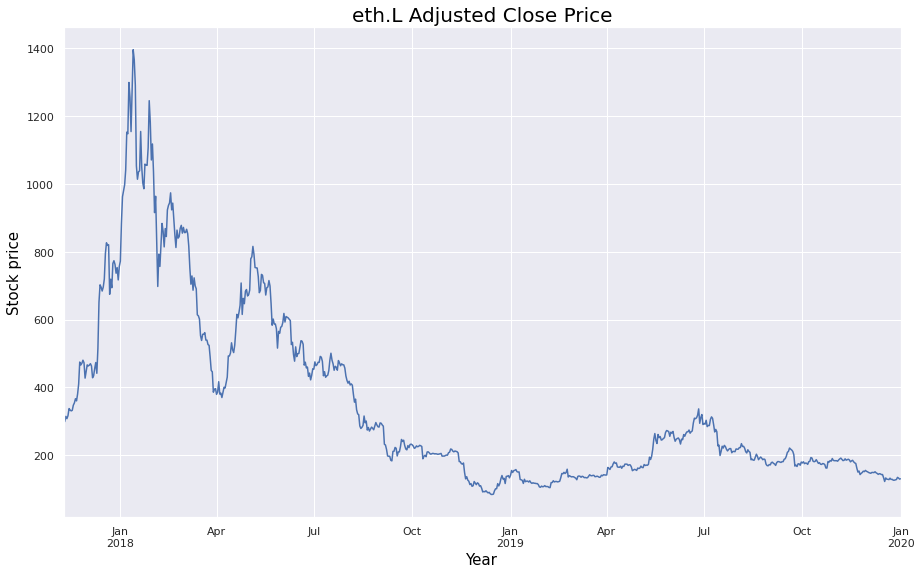

In [ ]:
# Plot Adjusted Close price

eth_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(20, 20)})
plt.title('eth.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

## 4. Moving Average

We will start with a simple moving average model whereby the next observation is the mean of all past observations creating a constantly updated average price.



In [ ]:
# Create DataFrame for Adjusted Close price

eth_adj = eth_df[['Adj Close']]
eth_adj 

,Adj Close
Date,
2017-11-09,320.88
2017-11-10,299.25
2017-11-11,314.68
2017-11-12,307.91
2017-11-13,316.72
...,...
2019-12-28,128.32
2019-12-29,134.76
2019-12-30,132.63



### Split the data

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [ ]:
# Creating 80%/20% split

split = int(0.8*len(eth_adj))

In [ ]:
# Splitting into train and test

train, test = eth_adj[:split], eth_adj[split:]

In [ ]:
eth_adj.shape, train.shape, test.shape

((784, 1), (627, 1), (157, 1))

In [ ]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2017-11-09 00:00:00'),
 Timestamp('2019-07-28 00:00:00'),
 Timestamp('2019-07-29 00:00:00'),
 Timestamp('2020-01-01 00:00:00'))

### Create predictions for the test set

In [ ]:
# Make predictions
preds = []
for i in range(0,157):
    a = train[len(train)-157+i:].sum() + sum(preds)
    b = a/157
    preds.append(b)

### Calculate the RMSE using the actual values

We will evaluate the model by calculating the RMSE, or the standard deviation of the residuals, a good measure of how accurately the model predicts the reponse.

In [ ]:
# Calculate rmse
rmse = np.sqrt(np.mean(np.power((np.array(test)-preds),2)))
rmse

62.878681231717486

### Visualise predicted values along with the actual values

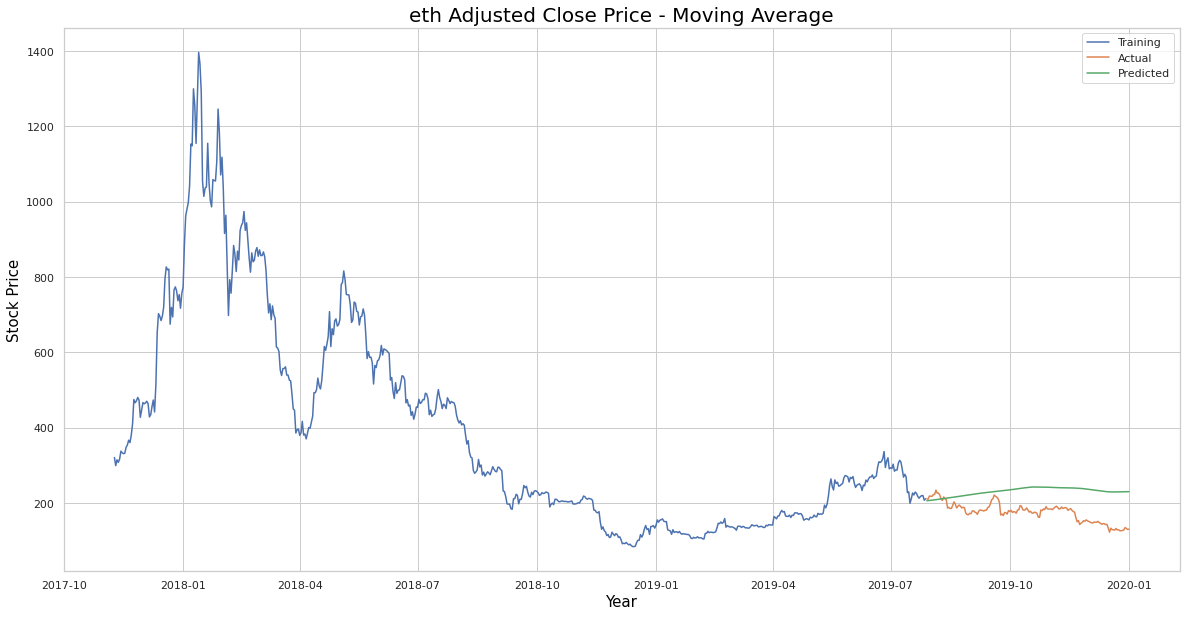

In [ ]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(train, label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("eth Adjusted Close Price - Moving Average", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

## 7. Auto ARIMA

ARIMA models explain a given time series based on its own past values, that is, its own lags (p) and lagged forecast errors (q), so that equation can be used to forecast future values. The 'd' parameter indicates how many times the data must be differenced in order to produce a stationary signal with a constant mean over time. This encapsulates ARIMA's holistic nature.

Auto ARIMA automatically generates the best (p,q,d) combination for the data set in order to provide better forecasting.

In [ ]:
# Create Adjusted Close price DataFrame

eth_adj = eth_df[['Adj Close']]
eth_adj 

,Adj Close
Date,
2017-11-09,320.88
2017-11-10,299.25
2017-11-11,314.68
2017-11-12,307.91
2017-11-13,316.72
...,...
2019-12-28,128.32
2019-12-29,134.76
2019-12-30,132.63


### Split the data into train and test sets

In [ ]:
split = int(0.8*len(eth_adj))

In [ ]:
train, test = eth_adj[:split], eth_adj[split:]

In [ ]:
eth_adj.shape, train.shape, test.shape

((784, 1), (627, 1), (157, 1))

### Create, train and test model

In [ ]:
# Create model to find best parameters
model = auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
# Train model
model.fit(train)
# Make predictions on test set
forecast = model.predict(n_periods=157)
# Create DataFrame for Predictions
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6421.729, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6244.462, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6423.184, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6143.814, Time=1.00 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6143.066, Time=0.71 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=6242.626, Time=0.29 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.61 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6143.872, Time=1.04 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=6145.530, Time=3.12 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=6144.9

### Calculate the RMSE using the actual values

In [ ]:
rmse = np.sqrt(np.mean(np.power((np.array(test['Adj Close'])-np.array(forecast['Prediction'])),2)))
rmse

### Print results and plot residuals of optimised model

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  784
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3701.270
Date:                Thu, 05 May 2022   AIC                           7404.541
Time:                        21:29:28   BIC                           7409.204
Sample:                    11-09-2017   HQIC                          7406.334
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       747.1016     12.830     58.230      0.000     721.955     772.248
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):              7681.77
Prob(Q):                              0.18   Pr

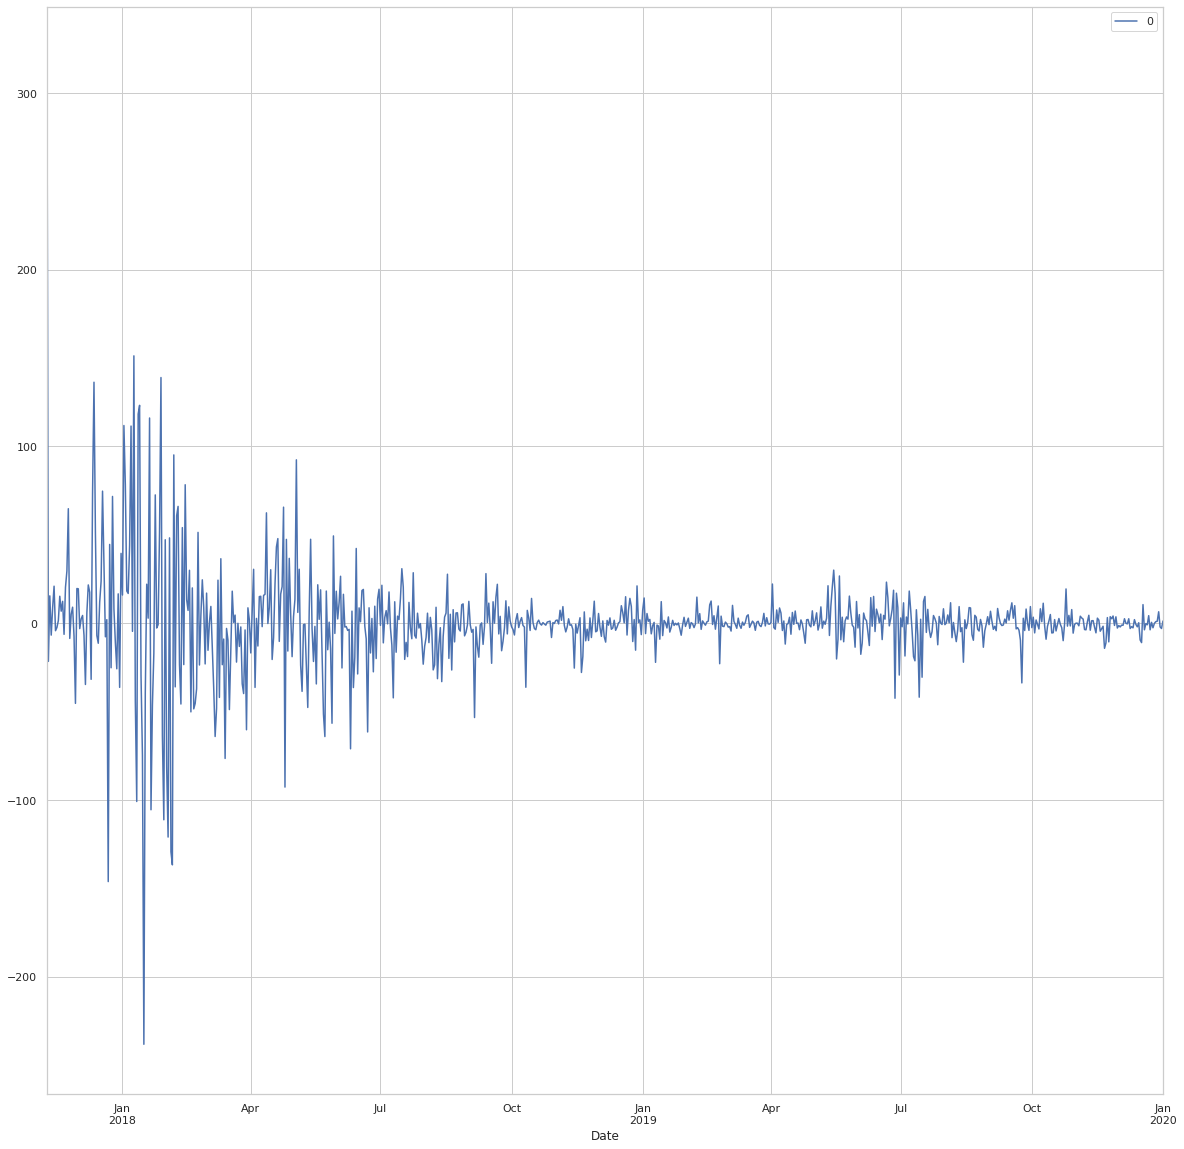

In [ ]:
import statsmodels.api as sm
# Create model with best parameters and print results
model = sm.tsa.arima.ARIMA(eth_adj['Adj Close'], order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot();

### Visualise predicted values along with the actual values

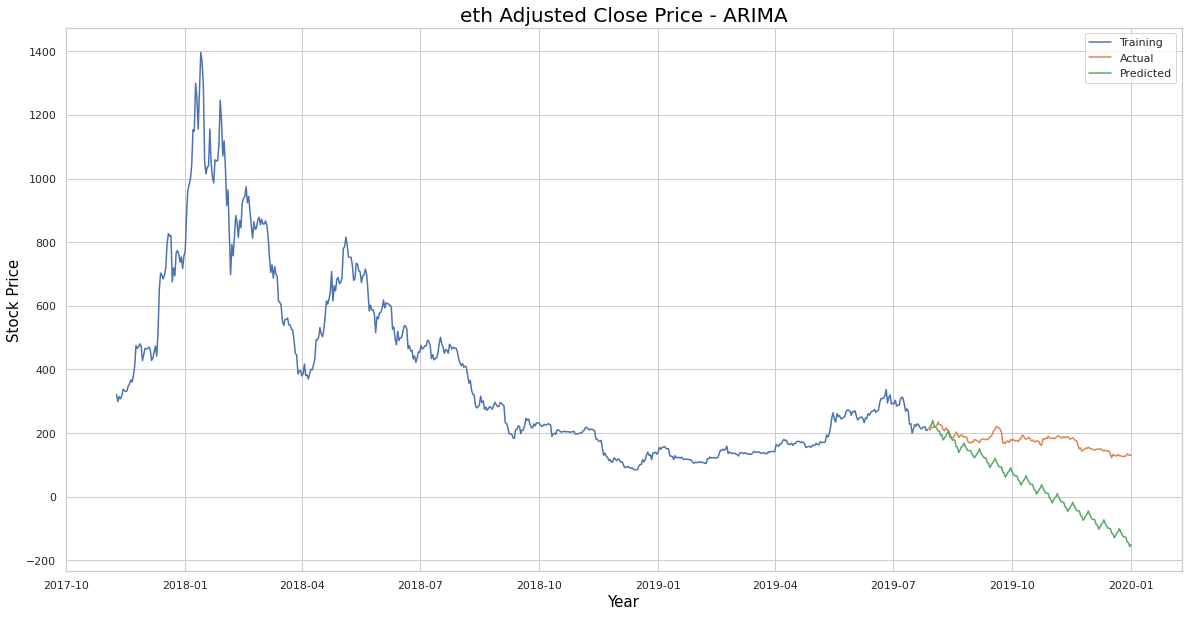

In [ ]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(forecast['Prediction'], label='Predicted')
plt.title("eth Adjusted Close Price - ARIMA", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

## Prophet Model

We'll use a time series model that considers both a series' trend and seasonality. Prophet is a package from Facebook that forecasts time series data using an additive model that fits non-linear trends including yearly, monthly, and daily seasonality as well as holiday impacts.

### Prepare and format data

In [ ]:
# Create data set with Adjusted CLose and Date Columns
eth_adj = pd.DataFrame(index=range(0,len(eth_df)),columns=['Date', 'Adj Close'])

for i in range(0,len(eth_df)):
     eth_adj['Date'][i] = eth_df.index[i]
     eth_adj['Adj Close'][i] = eth_df['Adj Close'][i]

In [ ]:
# Format date
eth_adj['Date'] = pd.to_datetime(eth_adj.Date,format='%Y-%m-%d')
eth_adj.index = eth_adj['Date']

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The **ds** (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date. The **y** column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
# Preparing data
eth_adj.rename(columns={'Adj Close': 'y', 'Date': 'ds'}, inplace=True)

### Split the data into train and test sets

In [ ]:
split = int(0.8*len(eth_adj))

In [ ]:
train, test = eth_adj[:split], eth_adj[split:]

In [ ]:
eth_adj.shape, train.shape, test.shape

((784, 2), (627, 2), (157, 2))

### Create and train model

In [ ]:
# Instantiate Prophet object  
model = Prophet()
# Fit the model
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Test model

Predictions are then made on the DataFrame with the **ds** column containing the dates for which a prediction is to be made. 

In [ ]:
# Make predictions  
adj_close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(adj_close_prices)

### Calculate the RMSE using the actual values

In [ ]:
#rmse
forecast_test = forecast['yhat'][split:]
rmse = np.sqrt(np.mean(np.power((np.array(test['y'])-np.array(forecast_test)),2)))
rmse

186.5246493141042

### Visualise predicted values along with the actual values

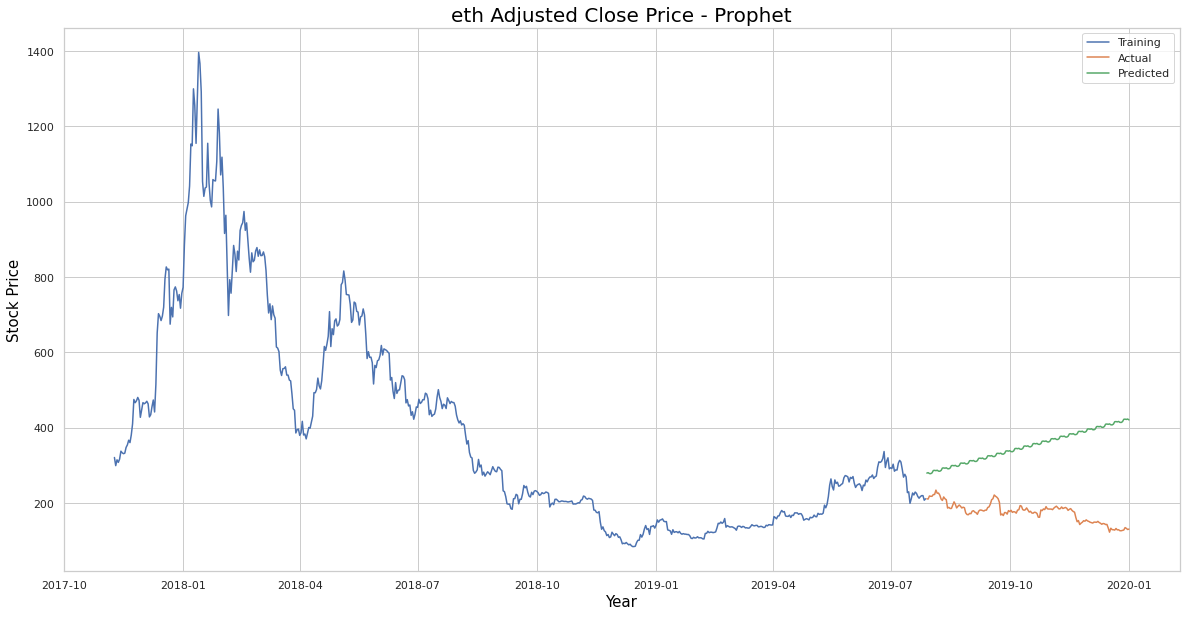

In [ ]:
# Plot predicted vs actual values
test['Predictions'] = 0
test['Predictions'] = forecast_test.values

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['y'], label='Training')
plt.plot(test['y'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("eth Adjusted Close Price - Prophet", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

We will specify 365 days into the future using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [ ]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
987,2020-07-23
988,2020-07-24
989,2020-07-25
990,2020-07-26
991,2020-07-27


In [ ]:
# Make predictions on future 365 days
forecast = model.predict(future)

The predict method will assign each row in **future** a predicted value which it names **yhat**. If you pass in historical dates, it will provide an in-sample fit. The **forecast** object here is a new DataFrame that includes a column **yhat** with the forecast, as well as columns for components and uncertainty intervals.

In [ ]:
# Print forecast object DataFrame

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
987,2020-07-23,608.107713,-585.965517,1734.750934
988,2020-07-24,610.251573,-586.349645,1752.990955
989,2020-07-25,616.565479,-597.453888,1775.817669
990,2020-07-26,616.910286,-605.924975,1748.881488
991,2020-07-27,616.166617,-610.255060,1774.850048


### Plot forecast and trend changepoints

Time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

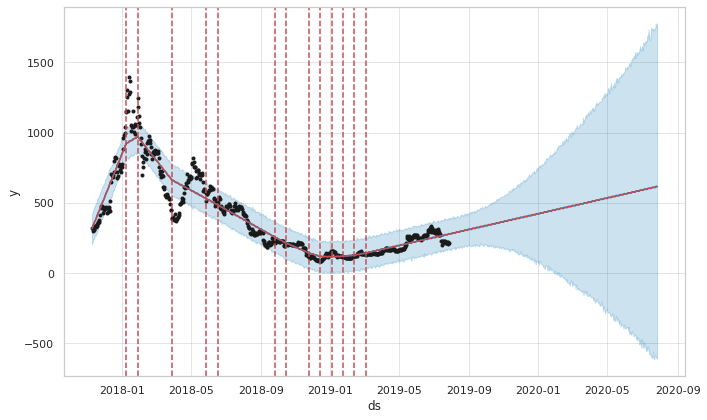

In [ ]:
# Plot forecast
fig = model.plot(forecast)
# The change points are added to our plot 
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### Extract changepoints

If we want to use something like this in a model, we need a way of extracting changepoint data.

In [ ]:
model.changepoints

20    2017-11-29
40    2017-12-19
60    2018-01-08
80    2018-01-28
100   2018-02-17
120   2018-03-09
140   2018-03-29
160   2018-04-18
180   2018-05-08
200   2018-05-28
220   2018-06-17
240   2018-07-07
260   2018-07-27
280   2018-08-16
300   2018-09-05
320   2018-09-25
340   2018-10-15
360   2018-11-04
380   2018-11-24
400   2018-12-14
420   2019-01-03
440   2019-01-23
460   2019-02-12
480   2019-03-04
500   2019-03-24
Name: ds, dtype: datetime64[ns]

### Plot components of the forecasts

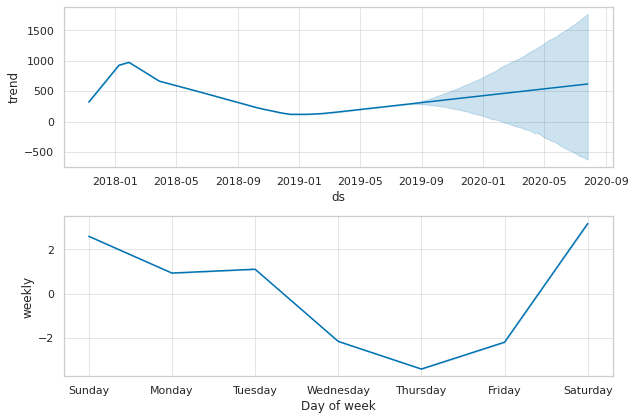

In [ ]:
# Plot the trend, weekly and yearly components

model.plot_components(forecast)
plt.show()

## Long Short Term Memory (LSTM)

An LSTM is a Recurrent Neural Network that can remember significant past information while forgetting irrelevant data. It presents the notion of gates for managing the flow of information in the network by having input, output, and forget gates, and it leverages short-term memory processes to generate longer memory.

In [ ]:
# Create DataFrame for Adjusted Close price
eth_adj = eth_df[['Adj Close']]
eth_adj 

,Adj Close
Date,
2017-11-09,320.88
2017-11-10,299.25
2017-11-11,314.68
2017-11-12,307.91
2017-11-13,316.72
...,...
2019-12-28,128.32
2019-12-29,134.76
2019-12-30,132.63


In [ ]:
# Convert DataFrame to numpy array
eth_adj_arr = eth_adj.values

### Split the data into train and test sets

In [ ]:
split = int(0.8*len(eth_adj_arr))

In [ ]:
train, test = eth_adj_arr[:split], eth_adj_arr[split:]

In [ ]:
train.shape, test.shape

((627, 1), (157, 1))

### Feature scaling

Normalise data by scaling to a range of 0 to 1 to improve learning and convergence of model.

In [ ]:
# Feature scaling and fitting scaled data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(eth_adj_arr)

## Create training data

In [ ]:
# Creating a data structure with 60 time-steps and 1 output

X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [ ]:
# Convert X_train and y_train to numpy arrays for training LSTM model

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(567, 60, 1)

### Create and train model

We will implement a simple model comprising one hidden layer with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer, then fitted on the training set for one epoch with a batch size of one.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 504 values, using past 60 from the train data
inputs = eth_adj_arr [len(eth_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

567/567 - 25s - loss: 0.0052 - 25s/epoch - 45ms/step


### Create test set

In [ ]:
# Create test data set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

# Convert data to numpy array
X_test = np.array(X_test)

# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
adj_closing_price = model.predict(X_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

In [ ]:
print(X_test.shape)

(157, 60, 1)


### Calculate the RMSE using the actual values

In [ ]:
rmse = np.sqrt(np.mean(np.power((test - adj_closing_price),2)))
rmse

33.279381327325254

### Visualise predicted values along with the actual values

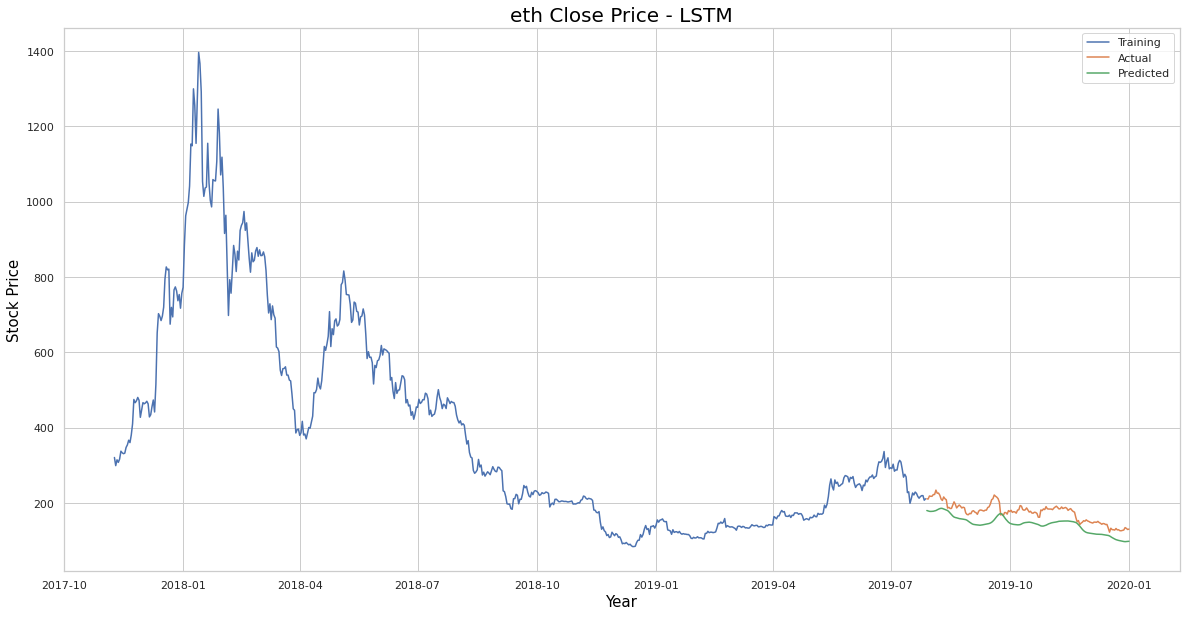

In [ ]:
# Plot predicted vs actual values
train = eth_adj[:split]
test = eth_adj[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("eth Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

## Including Covid period and performing prophet model

In [ ]:
eth_df = yf.download("ETH-USD", start="2012-05-05", end="2022-05-05")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%***********************]  1 of 1 completed


In [ ]:
eth_df

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2017-11-09,320.88,308.64,329.45,307.06,320.88,893249984
2017-11-10,299.25,320.67,324.72,294.54,299.25,885985984
2017-11-11,314.68,298.59,319.45,298.19,314.68,842300992
2017-11-12,307.91,314.69,319.15,298.51,307.91,1613479936
2017-11-13,316.72,307.02,328.42,307.02,316.72,1041889984
...,...,...,...,...,...,...
2022-05-01,2827.76,2729.99,2838.70,2728.08,2827.76,15332730152
2022-05-02,2857.41,2827.61,2874.15,2785.52,2857.41,18609741545
2022-05-03,2783.48,2857.15,2859.19,2762.12,2783.48,13026093219


## Prophet

In [ ]:
# Create data set with Adjusted CLose and Date Columns
eth_adj = pd.DataFrame(index=range(0,len(eth_df)),columns=['Date', 'Adj Close'])

for i in range(0,len(eth_df)):
     eth_adj['Date'][i] = eth_df.index[i]
     eth_adj['Adj Close'][i] = eth_df['Adj Close'][i]

In [ ]:
# Format date
eth_adj['Date'] = pd.to_datetime(eth_adj.Date,format='%Y-%m-%d')
eth_adj.index = eth_adj['Date']

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The **ds** (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date. The **y** column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
# Preparing data
eth_adj.rename(columns={'Adj Close': 'y', 'Date': 'ds'}, inplace=True)

### Split the data into train and test sets

In [ ]:
split = int(0.8*len(eth_adj))

In [ ]:
train, test = eth_adj[:split], eth_adj[split:]

In [ ]:
eth_adj.shape, train.shape, test.shape

((1639, 2), (1311, 2), (328, 2))

### Create and train model

In [ ]:
# Instantiate Prophet object  
model = Prophet()
# Fit the model
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Test model

Predictions are then made on the DataFrame with the **ds** column containing the dates for which a prediction is to be made. 

In [ ]:
# Make predictions  
adj_close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(adj_close_prices)

### Calculate the RMSE using the actual values

In [ ]:
#rmse
forecast_test = forecast['yhat'][split:]
rmse = np.sqrt(np.mean(np.power((np.array(test['y'])-np.array(forecast_test)),2)))
rmse

1697.8715667725533

### Visualise predicted values along with the actual values

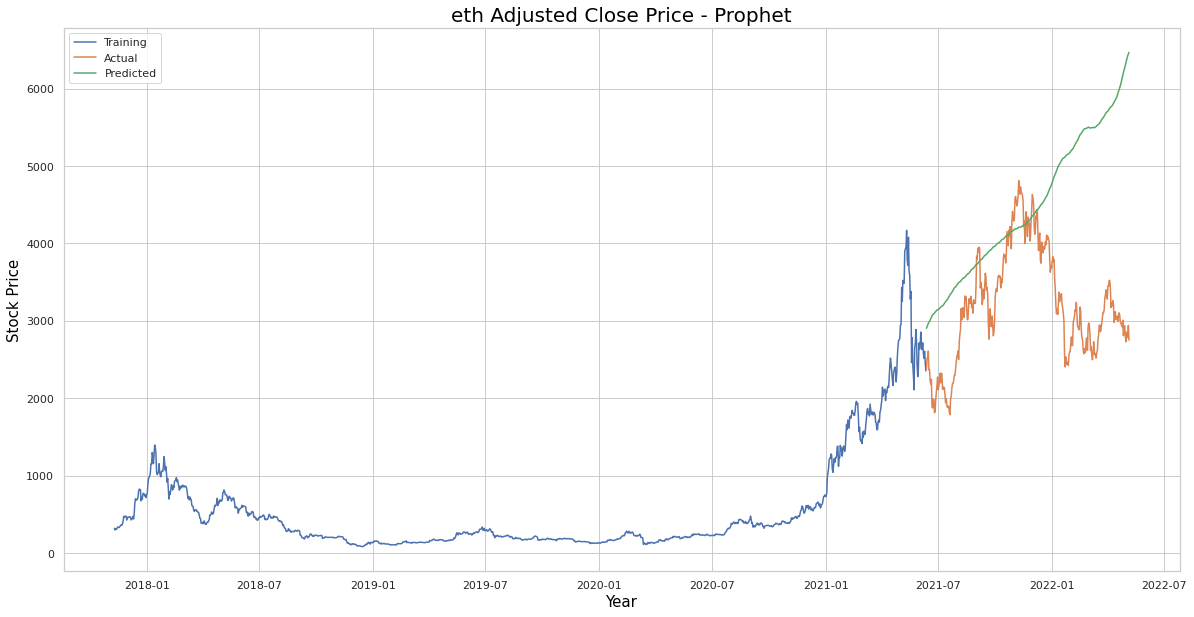

In [ ]:
# Plot predicted vs actual values
test['Predictions'] = 0
test['Predictions'] = forecast_test.values

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['y'], label='Training')
plt.plot(test['y'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("eth Adjusted Close Price - Prophet", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

In [ ]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
1671,2022-06-07
1672,2022-06-08
1673,2022-06-09
1674,2022-06-10
1675,2022-06-11


In [ ]:
# Make predictions on future 365 days
forecast = model.predict(future)

The predict method will assign each row in **future** a predicted value which it names **yhat**. If you pass in historical dates, it will provide an in-sample fit. The **forecast** object here is a new DataFrame that includes a column **yhat** with the forecast, as well as columns for components and uncertainty intervals.

In [ ]:
# Print forecast object DataFrame

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1671,2022-06-07,6511.097774,5680.994179,7384.860857
1672,2022-06-08,6522.548880,5688.104369,7369.953238
1673,2022-06-09,6536.454266,5702.570052,7428.076463
1674,2022-06-10,6552.542838,5706.556446,7456.500715
1675,2022-06-11,6575.051249,5729.641641,7451.889366


In [ ]:
forecast[['ds', 'yhat']]

,ds,yhat
0,2017-11-09,611.146958
1,2017-11-10,604.118366
2,2017-11-11,602.977436
3,2017-11-12,597.451638
4,2017-11-13,597.232778
...,...,...
1671,2022-06-07,6511.097774
1672,2022-06-08,6522.548880
1673,2022-06-09,6536.454266
1674,2022-06-10,6552.542838


### Plot forecast and trend changepoints

Time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

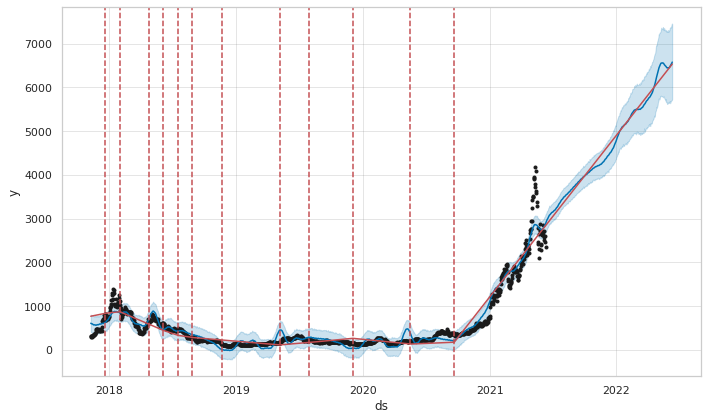

In [ ]:
# Plot forecast
fig = model.plot(forecast)
# The change points are added to our plot 
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### Extract changepoints

If we want to use something like this in a model, we need a way of extracting changepoint data.

In [ ]:
model.changepoints

42     2017-12-21
84     2018-02-01
126    2018-03-15
168    2018-04-26
209    2018-06-06
251    2018-07-18
293    2018-08-29
335    2018-10-10
377    2018-11-21
419    2019-01-02
461    2019-02-13
503    2019-03-27
544    2019-05-07
586    2019-06-18
628    2019-07-30
670    2019-09-10
712    2019-10-22
754    2019-12-03
796    2020-01-14
838    2020-02-25
879    2020-04-06
921    2020-05-18
963    2020-06-29
1005   2020-08-10
1047   2020-09-21
Name: ds, dtype: datetime64[ns]

### Plot components of the forecasts

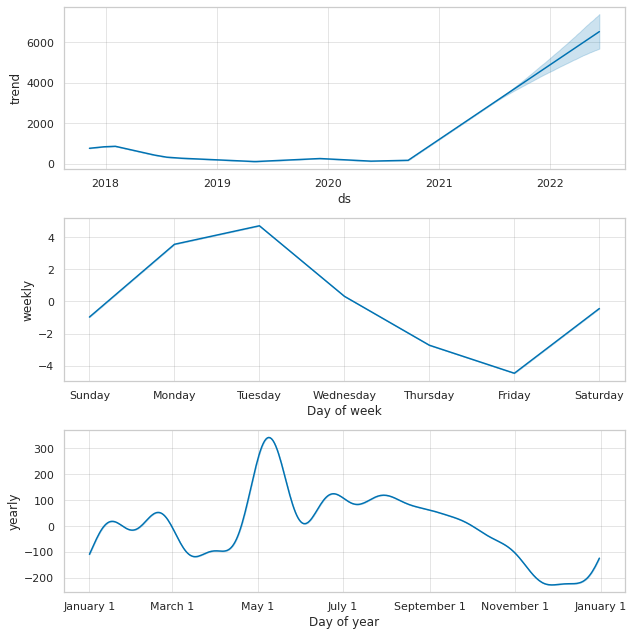

In [ ]:
# Plot the trend, weekly and yearly components

model.plot_components(forecast)
plt.show()

## Including Covid period and performing LSTM model

## Long Short Term Memory (LSTM)

An LSTM is a Recurrent Neural Network that can remember significant past information while forgetting irrelevant data. It presents the notion of gates for managing the flow of information in the network by having input, output, and forget gates, and it leverages short-term memory processes to generate longer memory.

In [ ]:
# Create DataFrame for Adjusted Close price
eth_adj = eth_df[['Adj Close']]
eth_adj 

,Adj Close
Date,
2017-11-09,320.88
2017-11-10,299.25
2017-11-11,314.68
2017-11-12,307.91
2017-11-13,316.72
...,...
2022-05-01,2827.76
2022-05-02,2857.41
2022-05-03,2783.48


In [ ]:
# Convert DataFrame to numpy array
eth_adj_arr = eth_adj.values

### Split the data into train and test sets

In [ ]:
split = int(0.8*len(eth_adj_arr))

In [ ]:
train, test = eth_adj_arr[:split], eth_adj_arr[split:]

In [ ]:
train.shape, test.shape

((1311, 1), (328, 1))

### Feature scaling

Normalise data by scaling to a range of 0 to 1 to improve learning and convergence of model.

In [ ]:
# Feature scaling and fitting scaled data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(eth_adj_arr)

## Create training data

In [ ]:
# Creating a data structure with 60 time-steps and 1 output

X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [ ]:
# Convert X_train and y_train to numpy arrays for training LSTM model

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1251, 60, 1)

### Create and train model

We will implement a simple model comprising one hidden layer with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer, then fitted on the training set for one epoch with a batch size of one.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 504 values, using past 60 from the train data
inputs = eth_adj_arr [len(eth_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

1251/1251 - 39s - loss: 0.0019 - 39s/epoch - 31ms/step


### Create test set

In [ ]:
# Create test data set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

# Convert data to numpy array
X_test = np.array(X_test)

# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
adj_closing_price = model.predict(X_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

In [ ]:
print(X_test.shape)

(328, 60, 1)


### Calculate the RMSE using the actual values

In [ ]:
rmse = np.sqrt(np.mean(np.power((test - adj_closing_price),2)))
rmse

296.8738254263934

### Visualise predicted values along with the actual values

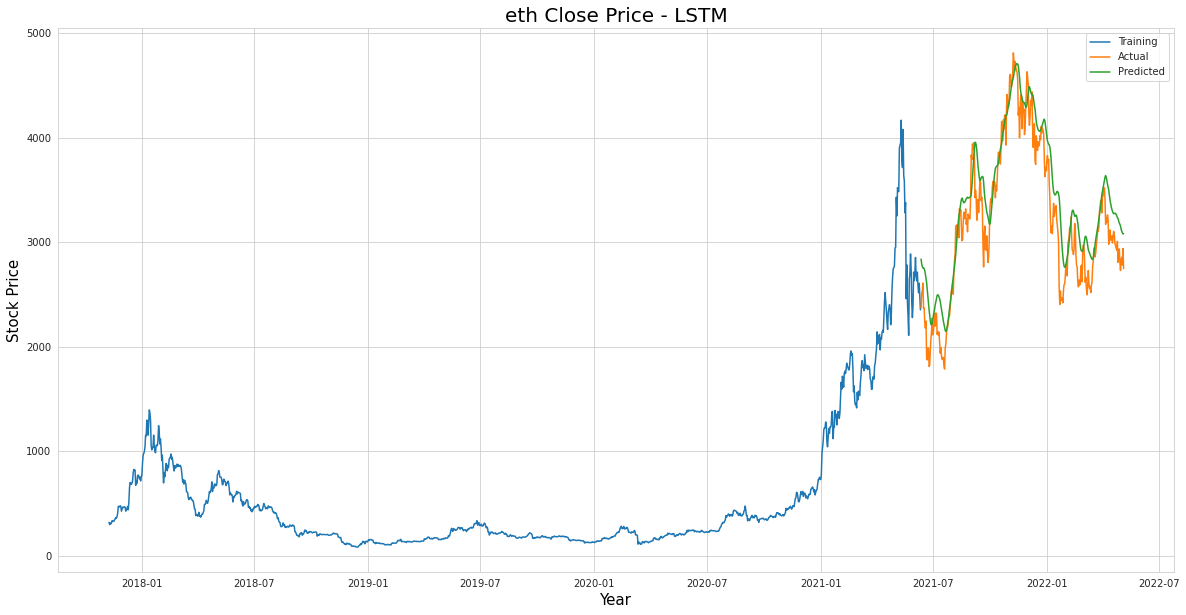

In [ ]:
# Plot predicted vs actual values
train = eth_adj[:split]
test = eth_adj[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("eth Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();